In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib.colors import ListedColormap
from itertools import product

# Логистическая регрессия

### 1. Переход от МНК к методу максимального правдоподобия 

Пусть в каждой точке пространства объектов $\mathbb{X}$ задана вероятность того, что объект $x$ будет принадлежать к классу "+1" $P(y=1|x)$ (условная вероятность $y = 1$ при условии $x$). Она будет принимать значения от 0 до 1, и нам нужно каким-то образом ее предсказывать, но пока мы умеем только строить прогноз методами линейной регрессии с помощью некоего алгоритма $b(x)=\left \langle w,x_{i} \right \rangle$. У него есть проблема, связанная с тем, что скалярное произведение $\left \langle w,x_{i} \right \rangle$ не всегда возвращает значения в отрезке [0, 1]. Если полученные вещественные значения отнормировать по шкале [0, 1], то это уже не будет вероятностью. Также, если будет необходимо возвращать значения в отрезке [0, 1], то максимальная ошибка для MSE будет единица. Чтобы достичь такого условия, можно использовать некую функцию $\sigma:\mathbb{R} \rightarrow [0,1]$, которая будет переводить полученное в скалярном произведении значение в вероятность, пределы которой будут лежать в промежутке от 0 до 1. В модели логистической регрессии в качестве такой функции берется сигмоида, которая имеет вид:

$$\sigma(z) = \frac{1}{1 + exp(-z)}.$$

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

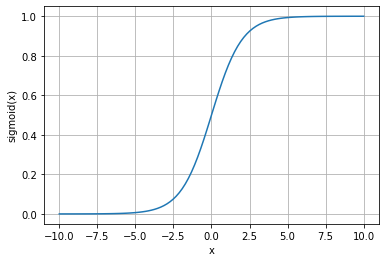

In [18]:
dots = np.linspace(-10, 10, 100)
sigmoid_value = list(map(sigmoid, dots))

plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.grid()
plt.plot(dots, sigmoid_value);

Одно из свойств сигмоиды - при нулевом аргументе она равна 0.5(50 процентов). Чем выше аргумент, тем сигмоида ближе к 1,
чем ниже - тем ближе к 0.

При использовании такой функции $\tilde{b}(x_{i}) = \sigma(\left \langle w,x_{i} \right \rangle)$ получаем, что вероятность отнесения объекта к классу "+1" $P(y=1|x)$, которую для краткости обозначим $p_{+}$, будет равняться

$$p_{+} = \sigma(\left \langle w,x_{i} \right \rangle) = \frac{1}{1 + exp(-\left \langle w,x_{i} \right \rangle)},$$

Чем больше будет скалярное произведение $\left \langle w,x_{i} \right \rangle$, тем выше будет предсказанная вероятность.

Чтобы понять, как его интерпретировать, выведем его из формулы выше:

$$\left \langle w,x_{i} \right \rangle = \text{ln} \frac{p_{+}}{1 - p_{+}}.$$

Таким образом, скалярное произведение вектора весов на вектор признаков представляет собой логарифм отношения вероятностей того, что y = 1 к вероятности того, что y = -1. Выражение под логарифмом называется _риском_, а вместе с логарифмом это выражение называется _логитом_. Поэтому метод и называется логистической регрессией: мы приближаем логит линейной комбинацией признаков и весов. Т.е. для того, чтобы решить проблему нахождения скалярного произведения матрицы весов на матрицу признаков, можно решать задачу при помощи MSE и получившийся ответ применить к сигмоиде.

### 2. Метод максимального правдоподобия

Далее для обучения этой модели нам потребуется использовать _метод максимального правдоподобия_. Его сущность заколючается в выборе гипотезы, при которой вероятность получить имеющееся наблюдение максимальна.

С точки зрения реализуемого алгоритма вероятность того, что в выборке встретится объект $x_{i}$ c классом $y_{i}$, равна

$$P(y=y_{i}|x_{i}) = p_{+}^{[y_{i}=+1]}(1-p_{+})^{[y_{i}=-1]}.$$

Исходя из этого, правдоподобие выборки (т.е. вероятность получить такую выборку с точки зрения алгоритма) будет равняться произведению вероятностей получения каждого имеющегося ответа:

$$P(y|X) = L(X) = \prod^{l}_{i=1} p_{+}^{[y_{i}=+1]}(1-p_{+})^{[y_{i}=-1]}.$$

### 3. Логарифмическая функция потерь

Правдоподобие можно использовать как функционал для обучения алгоритма, однако, удобнее взять от него логарифм, так как в этом случае произведение превратится в сумму(по свойству логарифма), а сумму гораздо проще оптимизировать. Также, в отличие от рассмотренных ранее функций потерь, правдоподобие требуется максимизировать для обучения алгоритма, а не минимизировать. Поэтому для большего удобства перед правдоподобием ставят минус, поскольку функции потери в задачах регрессии принято минимизировать. В итоге получим:

$$-\text{ln}L(X) = -\sum^{l}_{i=1}([y_{i} = +1] \text{ln}p_{+}) + [y_{i} = -1]\text{ln}(1 - p_{+}))).$$

![title](loggraph.gif)

Из графика видим, что логарифм от нуля не определён. Ноль под логарифмом может оказаться тогда, когда предсказанное значение 
класса прямо противоположно истинному, поскольку получим бесконечность и бесконечную ошибку. При использовании MSE ошибка может
быть равна максимум единице. Для алгоритма это свойство выполянет функцию очень сильного "штрафа" и он стремится предсказывать
значение вероятности(класса) точнее.

Если мы подставим в нее полученное ранее выражение для $p_{+}$ для сигмоиды, получим логарифмическую функцию потерь:

$$-\text{ln}L(X) = -\sum^{l}_{i=1}([y_{i} = +1] \text{ln}\frac{1}{1 + exp(-\left \langle w,x_{i} \right \rangle)}) + [y_{i} = -1]\text{ln}(1 - \frac{1}{1 + exp(-\left \langle w,x_{i} \right \rangle)}))) =$$

$$=-\sum^{l}_{i=1} \text{ln}(1 + exp(\left \langle w,x_{i} \right \rangle))$$

### 4. Оценка качества классификации

|  <empty>   | $$y = +1$$ | $$y = -1$$ |
--- | --- | ---
| __$$a(x) = +1$$__  |   TP    |   FP   |
| __$$a(x) = -1$$__ |   FN    |   TN   |

Cверху отложены истинные ответы, слева - ответы алгоритма. Когда алгоритм относит объект к классу "+1", говорят, что он _срабатывает_, а когда к "-1", - _пропускает_. Если алгоритм сработал (дал положительный ответ) и объект действительно относится к классу "+1", говорят, что имеет место верное срабатывание/верный положительный ответ (True Positive, TP), а если объект не относится к классу "+1", это ложное срабатывание (False Positive, FP). Если алгоритм пропускает объект, а его истинный класс "+1", это ложный пропуск/ложный негативные ответ (False Negative, FN), а если истинный класс объекта "-1", имеет место истинный пропуск (True Negative, TN). При такой классификации уже есть два вида ошибок - ложные срабатывания и ложные пропуски. По главной диагонали в матрице ошибок располагаются верные ответы, по побочной - неверные.

**Accuracy**`

Наиболее очевидным и простым способом является расчет _доли правильных ответов_:

$$accuracy(a,x) = \frac{TP+TN}{TP+TN+FP+FN}.$$

Эта метрика очень легко интерпретируется, однако, имеет определенные недостатки:

- Она может неадекватно работать на несбалансированных выборках, в которых объектов одного класса намного больше остальных: например, если у нас имеется выборка с 950 объектами класса +1 и 50 класса -1, обыкновенная константная модель классификатора, которая на всех объектах отдает ответ +1, будет иметь долю правильных ответов 0,95, при этом сам классификатор является абсолютно бесполезным. Методом борьбы с этим заключается в введении коэффициента $q_{0}$, равного доле объектов самого большого класса. Доля правильных ответов для корректных алгоритмов должна лежать в промежутке $[q_{0}, 1]$

- Она не учитывает "цены ошибок". В некоторых прикладных задачах ошибки разного рода могут иметь разную важность. Например, если говорить о кредитном скоринге, при постановке задачи необходимо определить, какая ошибка будет хуже: выдать кредит "плохому" клиенту или не выдать "хорошему". При этом используемая метрика качества должна учитывать цены разных ошибок.

**Точность и полнота**

Точность (precision) представляет из себя долю истинных срабатываний от общего количества срабатываний. Она показывает, насколько можно доверять алгоритму классификации в случае срабатывания

$$precision(a, X) = \frac{TP}{TP+FP}.$$

Полнота (recall) считается как доля объектов, истинно относящихся к классу "+1", которые алгоритм отнес к этому классу

$$recall(a, X) = \frac{TP}{TP+FN},$$

здесь $TP+FN$ как раз будут вместе составлять весь список объектов класса "+1".

Чтобы максимизировать precision, нужно чтобы было как можно меньше ошибок отнесения объекта к классу 1, когда в реальности
это событие - 0. Этот вариант подходит тогда, когда цена ошибки большая. Максимизировать recall можно при помощи минимизации количества случаев отнесения 
события к 0, когда в реальности это событие - 1(FN). Эту метрику лучше использовать тогда, когда цена воздействия на событие маленькая.

Например, если в задаче кредитного скоринга банк ставит цель возврата 90% кредитов, задачей ставится максимизация полноты при условии точности не ниже 0.9. А если при распознавании спама стоит требование, например, распознавать 95% спам-писем, задача состоит в максимизации точности при условии полноты не ниже 0.95.

**F1 мера(гармоническое среднее)**

В некоторых случаях требуется максимизировать и полноту и точность. _F-мера_ - это среднее гармоническое между точностью и полнотой.

$$F = \frac{2 \cdot precision \cdot recall }{ presision + recall}.$$

В отличие от, например, среднего арифметического, если хотя бы один из аргументов близок к нулю, то и среднее гармоническое будет близко к нулю.

**ROC - AUC**

Чтобы конвертировать вероятность в бинарную метку (сделать выводы о принадлежности к классу), нужно определить значение порога вероятности $t$, при котором объект нужно относить к соответствующему классу. Естественным кажется вариант, при котором порог равен 0,5, но он не всегда оказывается оптимальным. Зачастую интерес представляет сам вещественнозначный алгоритм $b(x)$, а порог будет выбираться позже в зависимости от требований к точности и полноте. В таком случае появляется потребность в измерении качества семейства алгоритмов $a(x)=[b(x)>t]$ с различными $t$.

Есть способы оценки модели в целом, не привязываясь к конкретному порогу. Первый из них основан на использовании _ROC-кривой_. Такая кривая строится в следующих координатах:

по оси $x$ откладывается доля ложных срабатываний (False Positive Rate) - отношение числа ложных срабатываний к общему размеру отрицательного класса:

$$FPR = \frac{FP}{FP+TN}$$

по оси $y$ откладывается доля верных срабатываний (True Positive Rate) - отношение числа верных срабатываний к размеру положительного класса:

$$TPR = \frac{TP}{TP+FN},$$

то есть TPR по сути представляет из себя полноту, о которой мы говорили ранее.

Точка на графике будет соответствовать конкретному классификатору с некоторым значением порога.

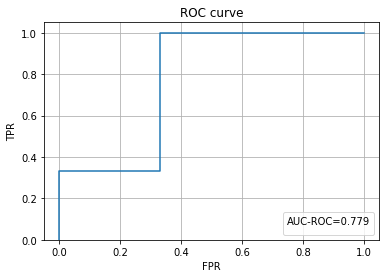

In [161]:
from numpy import trapz  # используем эту функцию для расчета площади под кривой

TPR = [0, 0.33, 0.33, 0.66, 1, 1, 1]
FPR = [0, 0, 0.33, 0.33, 0.33, 0.66, 1]

AUC_ROC = trapz(TPR, x = FPR, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR);

ROC кривая всегда идет из точки (0,0) в точку (1,1). При этом в случае наличия идеального классификатора с определенным порогом доля его верных ответов будет равна 1, а доля ложных срабатываний - 0, то есть график будет проходить через точку (0,1). Таким образом, чем ближе к этой точке проходит ROC-кривая, тем лучше наши оценки и лучше используемое семейство алгоритмов. Таким образом мерой качества оценок принадлежности к классу 1 может служить площадь под ROC-кривой. Такая метрика называется AUC-ROC (Area Under Curve - площадь под кривой ROC). В случае идеального алгоритма $AUC-ROC = 1$, а в случае худшего приближается к $\frac{1}{2}$.

Критерий AUC-ROC можно интерпретировать как вероятность того, что если выбрать случайные положительный и отрицательный объект выборки, положительный объект получит оценку принадлежности выше, чем отрицательный.

**PR-кривая**

AUC-ROC не очень устойчив к несбалансированным выборкам. Допустим, нам нужно выбрать 100 релевантных документов из выборки в 1000000 документов. И у нас есть алгоритм, который дает выборку из 5000 документов, 90 из которых релевантны. В этом случае 

$$TPR=\frac{TP}{TP+FN} = \frac{90}{90+10}=0.9$$

$$FPR=\frac{FP}{FP+TN} = \frac{4910}{4910+994990}=0.00491$$,

Что является показателями очень хорошего алгоритма - AUC-ROC будет близка к 1, хотя на самом деле 1900 из 2000 выданных документов являются нерелевантными.

Чтобы посмотреть реальное положение дел, рассчитаем точность и полноту:

$$precision = \frac{TP}{TP+FP}=\frac{90}{90+4910} = 0.018$$

$$recall = TPR = 0.9.$$

Здесь уже видно, что алгоритм является недостаточно точным.

Таким образом, если размер положительного класс значительно меньше отрицательного, AUC-ROC может давать неадекватную оценку качества алгоритма, так как измеряет долю ложных срабатываний относительно общего числа отрицательных объектов, и если оно большое, доля будет мала, хотя в абсолютном значении количество ложных срабатываний может заметно превышать количество верных срабатываний.

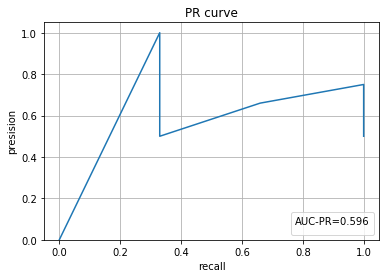

In [164]:
precision = [0, 1, 0.5, 0.66, 0.75, 0.6, 0.5]
recall = [0, 0.33, 0.33, 0.66, 1, 1, 1]

AUC_PR = trapz(precision, x = recall, dx=0.1)

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall, precision);

Она всегда стартует в точке (0,0) и заканчивается в точке (1, r), где r - доля положительных объектов в выборке. В случае наличия идеального классификатора, у которого точность и полнота 100%, кривая пройдет через точку (1,1). Таким образом, чем ближе к этой точке кривая проходит, тем лучше оценки. Так что, как и в случае ROC-кривой, можно ввести метрику качества в виде площади под PR-кривой AUC-PR.

### 5. Примеры

In [175]:
n_samples = 5000
n_features = 5
n_informative= 3
n_classes=2
noise = 15
rng = np.random.RandomState(42)
classes = datasets.make_classification(n_samples, n_features, n_informative,
                                      n_classes, random_state=rng)
shuffle_index = np.random.permutation(classes[0].shape[0])
X, y = classes[0][shuffle_index], classes[1][shuffle_index]

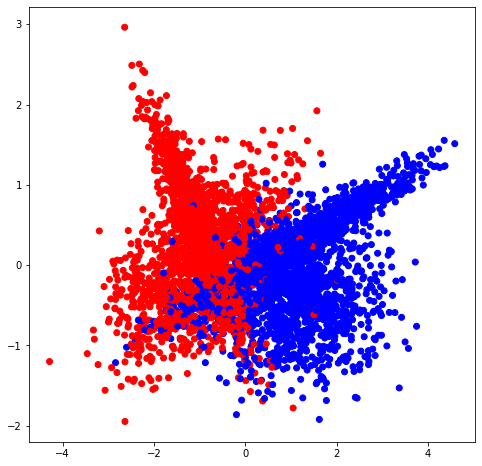

In [42]:
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

### 5.1. Логистическая функция потерь

In [44]:
#Проверка на ненулевое выражение под логарифмом
def log_checking(y_pred):
    for y_pred in range(len(y_pred)):
        assert y_pred != 0, 'Под логарифмом не может быть нулевого выражения'
        assert y_pred != 1, 'Под логарифмом не может быть нулевого выражения'

In [46]:
#Подсчёт логистической функции потерь с проверкой на ненулевое выражение под логарифмом
def calc_logloss(y, y_pred):
    #log_checking(y_pred)
    err = - np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    return err

### 5.2. Минимизация log_loss

Реализуем функцию потерь log loss с одновременным расчетом градиента.
Оптимизировать функционал ошибки будем с помощью градиентного спуска, его вид в случае использования такой функции потерь будет:

$$w_{n+1} = w_{n} - \eta \frac{1}{l}X(A-Y)^{T},$$

где $A=\frac{1}{1 + exp(-\left \langle w,x_{i} \right \rangle)}.$

In [32]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [37]:
def eval_logit(X, y, iterations=None, alpha=None):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    for i in range(1, iterations+1):
        z = np.dot(W.T, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
    
    if i % (iterations / 10) == 0:
        print(i, W, err)
    
    return W

In [34]:
grid = {
    'iterations': np.array([100, 300, 700]),
    'learning_rate': np.array([0.05, 0.01, 0.1])
}

In [49]:
for iter_num, alpha in product(grid['iterations'], grid['learning_rate']):
    W = eval_logit(X.T, y, iterations=iter_num, alpha=alpha)

100 [1.38750897 0.18823511 0.49594101 0.92559571 0.07678743] 0.3002862285078457
100 [ 0.82046292 -0.02749196  0.58133872  1.33633583 -0.09129942] 0.460618408862738
100 [1.65334071 0.28490315 0.4958145  0.72261628 0.13294035] 0.27399818537779647
300 [1.78998844 0.32457894 0.51788926 0.63517657 0.16860974] 0.26765966848519246
300 [1.18602364 0.10963305 0.51860383 1.08199831 0.02863633] 0.3372081144880116
300 [1.97351619 0.36049774 0.58155671 0.54966215 0.23205785] 0.26389551010187307
700 [2.00120097 0.36409791 0.59484592 0.54002998 0.24314967] 0.2636498485620964
700 [1.5158329  0.23713189 0.49025164 0.82425929 0.10296944] 0.28447185092229194
700 [2.07120427 0.37153481 0.63190398 0.51862284 0.27252398] 0.2633587750105636


### 5.3. Функция, рассчитывающая вероятность отнесения к классу 1

In [52]:
def calc_pred_proba(W, X):
    y_pred_proba = 1/(1 + np.exp(-(np.dot(X,W))))
    return y_pred_proba

In [54]:
y_pred_proba = calc_pred_proba(W, X)
y_pred_proba

array([0.01591673, 0.28995842, 0.01026137, ..., 0.99924721, 0.91687602,
       0.20171001])

### 5.4. Функция, рассчитывающая вероятность отнесения к классу 0 или 1

In [104]:
# За порог отнесения к тому или иному классу примем вероятность 0.5
def calc_pred(W, X):
    m = y_pred_proba.shape[0]
    y_pred = np.zeros((1, m))
    y_pred = np.array([], dtype='int32')
    
    #y_pred_proba = calc_pred_proba(W, X)
    
    for i in y_pred_proba:
        
        if i > 0.5:
            y_pred = np.append(y_pred, 1)
        else:
            y_pred = np.append(y_pred, 0)
    
    return y_pred

In [105]:
y_pred = calc_pred(W, X)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

### 5.5. Расчёт Accuracy, матрицы ошибок, точности и полноты, F1 score

In [125]:
#Матрица ошибок 1 и 2 рода
def matrix_errors(y, y_pred):
    spam = list(zip(y, y_pred))
     
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i, j in enumerate(spam):
        if spam[i][0] == 1 and spam[i][1] == 1: #хорошего человека назвали хорошим
            TP += 1
        elif spam[i][0] < spam[i][1]: #плохого человека назвали хорошим
            FP += 1
        elif spam[i][0] < spam[i][1]: #хорошего человека назвали плохим
            FN += 1
        else:
            TN += 1 #плохого человека назвали плохим

    errors = np.array([TP, TN, FP, FN], dtype='int32')
    
    return errors

In [126]:
errors = matrix_errors(y, y_pred)
errors

array([2200, 2564,  236,    0])

In [133]:
#Accuracy
def calc_accuracy(errors):
    acc = (np.sum([errors[0],errors[1]]))/(np.sum([errors]))
    return acc

In [135]:
acc = calc_accuracy(errors)
acc

0.9528

In [137]:
#Precision
def calc_precision(errors):
    prec = errors[0]/(np.sum([errors[0], errors[2]]))   
    return prec

In [138]:
prec = calc_precision(errors)
prec

0.90311986863711

In [139]:
#Recall
def calc_recall(errors):
    rec = errors[0]/(np.sum([errors[0], errors[3]]))    #TP+FN
    return rec

In [140]:
rec = calc_recall(errors)
rec

1.0

In [141]:
#F1 score
def f1_score(prec, rec):
    f1 = (2*prec*rec)/(prec+rec)
    return f1

In [142]:
f1 = f1_score(prec, rec)
f1

0.9490940465918896

Модель могла переобучиться, поскольку мы не делали валидацию (на отложенной выборке, либо кроссвалидацию)

### 5.6. Реализация с L1 и L2 регуляризацией

In [213]:
def eval_logit(X, y, iterations=None, alpha=None, lambda_1=0, lambda_2=0): 
    
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        
        W -= alpha * ((1/n * np.dot((y_pred - y), X.T)) +  2 * lambda_2 * W + (lambda_1 * W)/(np.abs(lambda_1)))
    
        if i % (iterations // 3) == 0:
            print(i, W, err)
    
    return W

In [214]:
W = eval_logit(X.T, y, iterations=100, alpha=0.1, lambda_1=1e-4, lambda_2=1e-4)

33 [ 0.29290196 -0.00707671  0.12143159  0.0865313   0.23111615] 0.45105675347796587
66 [ 0.28022605 -0.01427925  0.12347639  0.06298708  0.25144817] 0.45052498735642693
99 [ 0.27975764 -0.01455647  0.12361946  0.06235172  0.25206038] 0.45051871775871316
